# Barcelona Housing & Demographics - Initial EDA
    
This notebook performs an initial Exploratory Data Analysis (EDA) on the consolidated database.

**Objectives:**
1. Data Quality Checks (NULLs, coverage, temporal gaps)
2. Price Distribution Analysis (venta y alquiler)
3. Demographic Analysis (básica y ampliada)
4. Income (Renta) Analysis
5. Correlation Analysis (precios, demografía, renta)
6. Geographic Visualization
7. Outlier Detection
8. Temporal Trends Analysis

**Última actualización**: 17 de noviembre de 2025


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
import json

# Configure plotting
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline

# Connect to database
DB_PATH = '../data/processed/database.db'
conn = sqlite3.connect(DB_PATH)

print("Libraries loaded and database connected.")

Libraries loaded and database connected.


## 1. Data Overview & Quality Checks

In [ ]:
# Load main tables
df_barrios = pd.read_sql("SELECT * FROM dim_barrios", conn)
df_precios = pd.read_sql("SELECT * FROM fact_precios", conn)
df_demo = pd.read_sql("SELECT * FROM fact_demografia", conn)
df_demo_amp = pd.read_sql("SELECT * FROM fact_demografia_ampliada", conn)
df_renta = pd.read_sql("SELECT * FROM fact_renta", conn)
df_idealista = pd.read_sql("SELECT * FROM fact_oferta_idealista", conn)

print("=== RESUMEN DE DATOS ===")
print(f"Barrios: {df_barrios.shape}")
print(f"Precios: {df_precios.shape}")
print(f"Demografia (básica): {df_demo.shape}")
print(f"Demografia (ampliada): {df_demo_amp.shape}")
print(f"Renta: {df_renta.shape}")
print(f"Oferta Idealista: {df_idealista.shape}")

# Cobertura temporal
print("\n=== COBERTURA TEMPORAL ===")
print(f"Demografia: {df_demo['anio'].min()} - {df_demo['anio'].max()}")
print(f"Precios: {df_precios['anio'].min()} - {df_precios['anio'].max()}")
if not df_renta.empty:
    print(f"Renta: {df_renta['anio'].min()} - {df_renta['anio'].max()}")
else:
    print("Renta: Sin datos")

Barrios: (73, 13)
Precios: (9927, 10)
Demografia: (657, 13)
Renta: (73, 13)


In [ ]:
# Check for NULLs in all tables
print("=== ANÁLISIS DE VALORES FALTANTES ===\n")

print("--- fact_precios ---")
nulls_precios = df_precios.isnull().sum()
print(nulls_precios[nulls_precios > 0])
print(f"Total registros: {len(df_precios)}")
print(f"Registros con precio_m2_venta: {df_precios['precio_m2_venta'].notna().sum()} ({df_precios['precio_m2_venta'].notna().sum()/len(df_precios)*100:.1f}%)")
print(f"Registros con precio_mes_alquiler: {df_precios['precio_mes_alquiler'].notna().sum()} ({df_precios['precio_mes_alquiler'].notna().sum()/len(df_precios)*100:.1f}%)")

print("\n--- fact_demografia ---")
nulls_demo = df_demo.isnull().sum()
print(nulls_demo[nulls_demo > 0])
if nulls_demo.sum() > 0:
    print(f"Total registros: {len(df_demo)}")
    for col in df_demo.columns:
        if df_demo[col].isnull().sum() > 0:
            pct = df_demo[col].isnull().sum() / len(df_demo) * 100
            print(f"  {col}: {df_demo[col].isnull().sum()} NULLs ({pct:.1f}%)")

print("\n--- fact_renta ---")
if not df_renta.empty:
    nulls_renta = df_renta.isnull().sum()
    print(nulls_renta[nulls_renta > 0])
    print(f"Total registros: {len(df_renta)}")
    print(f"Años únicos: {df_renta['anio'].nunique()}")
else:
    print("Sin datos")

print("\n--- fact_demografia_ampliada ---")
nulls_demo_amp = df_demo_amp.isnull().sum()
print(nulls_demo_amp[nulls_demo_amp > 0])
print(f"Total registros: {len(df_demo_amp)}")
print(f"Grupos de edad únicos: {df_demo_amp['grupo_edad'].nunique() if 'grupo_edad' in df_demo_amp.columns else 'N/A'}")
print(f"Nacionalidades únicas: {df_demo_amp['nacionalidad'].nunique() if 'nacionalidad' in df_demo_amp.columns else 'N/A'}")

--- Missing Values in fact_precios ---
id                        0
barrio_id                 0
anio                      0
periodo                   0
trimestre              9927
precio_m2_venta        1730
precio_mes_alquiler    8197
dataset_id                0
source                    0
etl_loaded_at             0
dtype: int64

--- Missing Values in fact_demografia ---
id                    0
barrio_id             0
anio                  0
poblacion_total       0
poblacion_hombres     0
poblacion_mujeres     0
hogares_totales       0
edad_media            0
porc_inmigracion     20
densidad_hab_km2      0
dataset_id            0
source                0
etl_loaded_at         0
dtype: int64


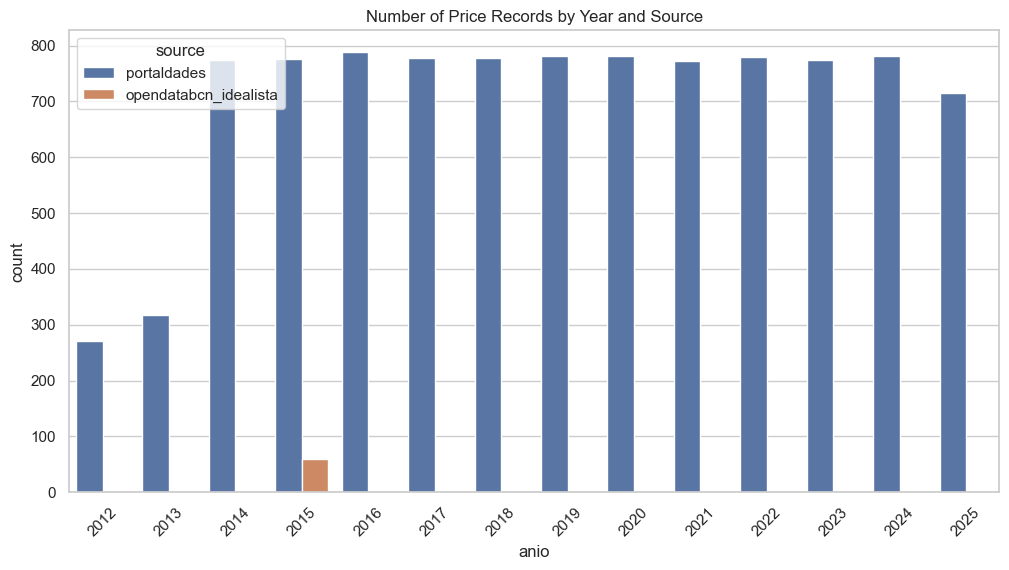

In [4]:
# Price records by Year and Source
plt.figure(figsize=(12, 6))
sns.countplot(data=df_precios, x='anio', hue='source')
plt.title('Number of Price Records by Year and Source')
plt.xticks(rotation=45)
plt.show()

## 2. Price Distribution Analysis

Análisis de distribución de precios de venta y alquiler por m².

In [5]:
# List available datasets in prices
dataset_counts = df_precios['dataset_id'].value_counts().head(10)
print("Top 10 Datasets by Record Count:")
print(dataset_counts)

Top 10 Datasets by Record Count:
dataset_id
mrslyp5pcq    993
bxtvnxvukh    988
hostlmjrdo    988
idjhkx1ruj    969
b37xv8wcjh    866
5ibudgqbrb    864
la6s9fp57r    860
u25rr7oxh6    859
9ap8lewvtt    857
cq4causxvu    857
Name: count, dtype: int64


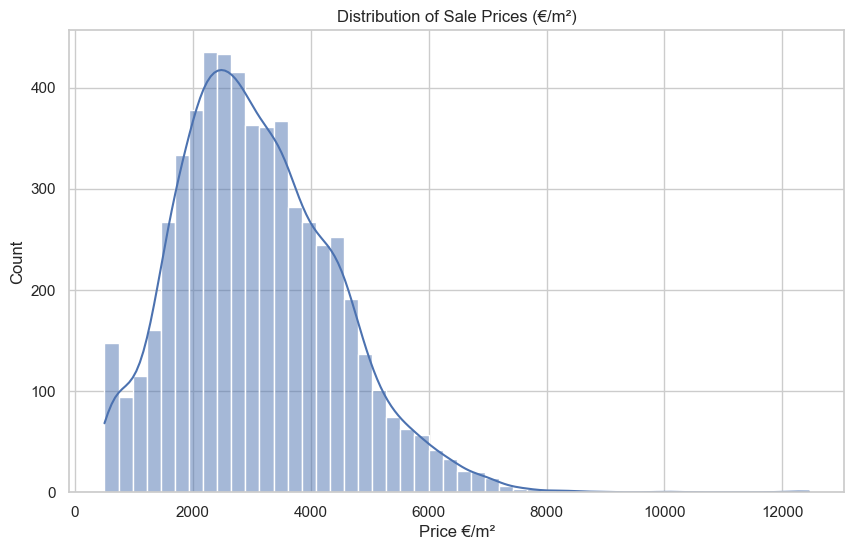

In [ ]:
# Filter for reasonable price/m2 values to exclude outliers and total prices
df_m2_venta = df_precios[
    (df_precios['precio_m2_venta'] > 500) & 
    (df_precios['precio_m2_venta'] < 15000)
].copy()

df_m2_alquiler = df_precios[
    (df_precios['precio_mes_alquiler'] > 5) & 
    (df_precios['precio_mes_alquiler'] < 50)
].copy()

# Estadísticas descriptivas
print("=== ESTADÍSTICAS DESCRIPTIVAS - PRECIOS ===")
print("\n--- Precio de Venta (€/m²) ---")
print(df_m2_venta['precio_m2_venta'].describe())

print("\n--- Precio de Alquiler (€/m²/mes) ---")
if not df_m2_alquiler.empty:
    print(df_m2_alquiler['precio_mes_alquiler'].describe())
else:
    print("Sin datos suficientes")

# Distribución de precios de venta
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_m2_venta['precio_m2_venta'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución de Precios de Venta (€/m²)')
axes[0].set_xlabel('Precio €/m²')
axes[0].axvline(df_m2_venta['precio_m2_venta'].median(), color='r', linestyle='--', label=f'Mediana: {df_m2_venta["precio_m2_venta"].median():.0f}€')
axes[0].legend()

if not df_m2_alquiler.empty:
    sns.histplot(df_m2_alquiler['precio_mes_alquiler'], bins=50, kde=True, ax=axes[1])
    axes[1].set_title('Distribución de Precios de Alquiler (€/m²/mes)')
    axes[1].set_xlabel('Precio €/m²/mes')
    axes[1].axvline(df_m2_alquiler['precio_mes_alquiler'].median(), color='r', linestyle='--', label=f'Mediana: {df_m2_alquiler["precio_mes_alquiler"].median():.2f}€')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Datos de alquiler\ninsuficientes', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Distribución de Precios de Alquiler (€/m²/mes)')

plt.tight_layout()
plt.show()

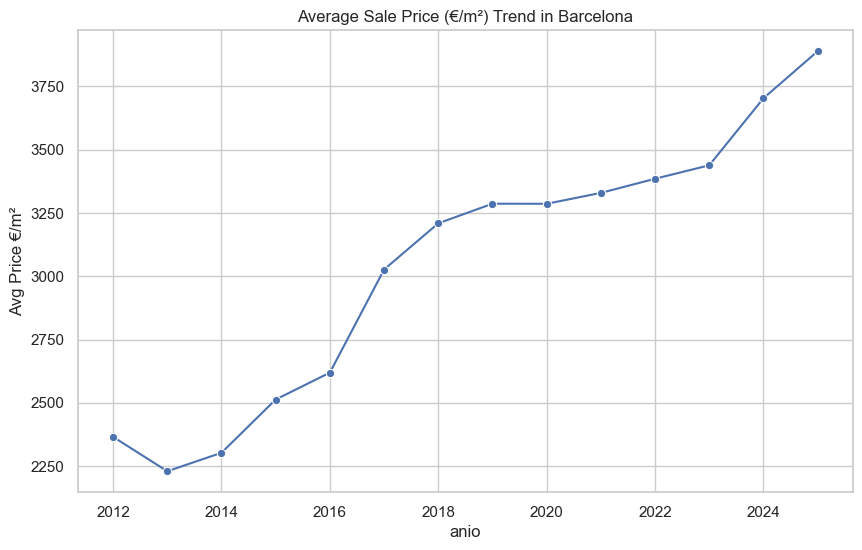

In [ ]:
# Price Trends over Time (Average and Median across all barrios)
price_trend_venta = df_m2_venta.groupby('anio')['precio_m2_venta'].agg(['mean', 'median', 'std']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Venta
axes[0].plot(price_trend_venta['anio'], price_trend_venta['mean'], marker='o', label='Media', linewidth=2)
axes[0].plot(price_trend_venta['anio'], price_trend_venta['median'], marker='s', label='Mediana', linewidth=2)
axes[0].fill_between(price_trend_venta['anio'], 
                     price_trend_venta['mean'] - price_trend_venta['std'],
                     price_trend_venta['mean'] + price_trend_venta['std'],
                     alpha=0.2, label='±1 desv. estándar')
axes[0].set_title('Tendencia de Precios de Venta (€/m²)')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Precio €/m²')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Alquiler (si hay datos)
if not df_m2_alquiler.empty:
    price_trend_alquiler = df_m2_alquiler.groupby('anio')['precio_mes_alquiler'].agg(['mean', 'median', 'std']).reset_index()
    axes[1].plot(price_trend_alquiler['anio'], price_trend_alquiler['mean'], marker='o', label='Media', linewidth=2)
    axes[1].plot(price_trend_alquiler['anio'], price_trend_alquiler['median'], marker='s', label='Mediana', linewidth=2)
    axes[1].fill_between(price_trend_alquiler['anio'],
                         price_trend_alquiler['mean'] - price_trend_alquiler['std'],
                         price_trend_alquiler['mean'] + price_trend_alquiler['std'],
                         alpha=0.2, label='±1 desv. estándar')
    axes[1].set_title('Tendencia de Precios de Alquiler (€/m²/mes)')
    axes[1].set_xlabel('Año')
    axes[1].set_ylabel('Precio €/m²/mes')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Datos de alquiler\ninsuficientes', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Tendencia de Precios de Alquiler (€/m²/mes)')

plt.tight_layout()
plt.show()

## 3. Demographic Analysis

### 3.1 Demografía Básica

/var/folders/8t/1rzjlj6n3rj3v08skl2pwjbm0000gn/T/ipykernel_76479/2539180631.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dist_pop, x='poblacion_total', y='distrito_nombre', palette='viridis')


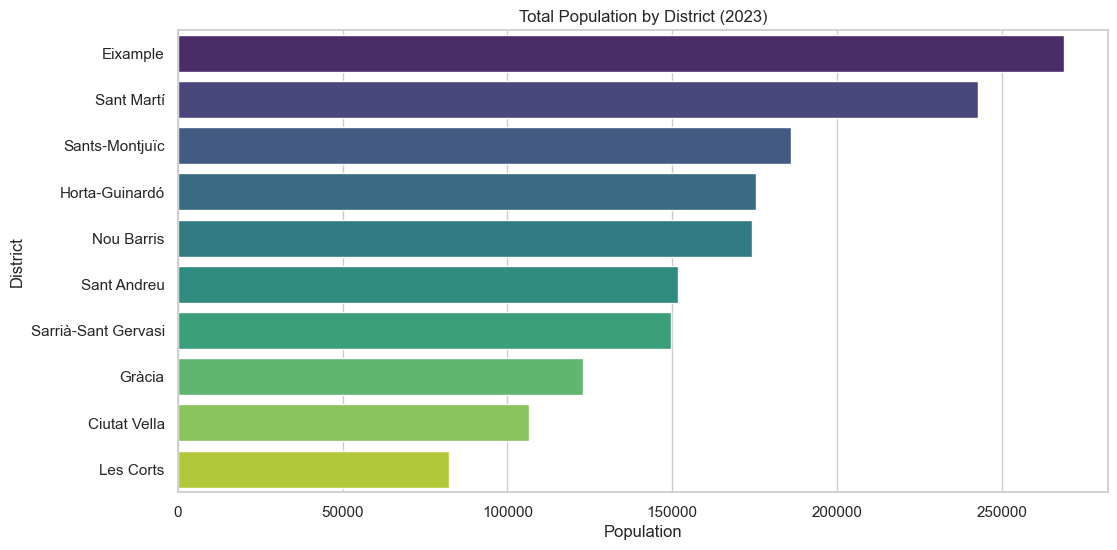

In [ ]:
# Population by District (using latest available year)
latest_year = df_demo['anio'].max()
df_demo_latest = df_demo[df_demo['anio'] == latest_year].merge(
    df_barrios[['barrio_id', 'barrio_nombre', 'distrito_nombre']], 
    on='barrio_id'
)

dist_pop = df_demo_latest.groupby('distrito_nombre')['poblacion_total'].sum().sort_values(ascending=False).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Población por distrito
sns.barplot(data=dist_pop, x='poblacion_total', y='distrito_nombre', ax=axes[0], palette='viridis')
axes[0].set_title(f'Población Total por Distrito ({latest_year})')
axes[0].set_xlabel('Población')
axes[0].set_ylabel('Distrito')

# Evolución temporal de población total
poblacion_temporal = df_demo.groupby('anio')['poblacion_total'].sum().reset_index()
axes[1].plot(poblacion_temporal['anio'], poblacion_temporal['poblacion_total'], marker='o', linewidth=2)
axes[1].set_title('Evolución de Población Total en Barcelona')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Población Total')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas demográficas
print("=== ESTADÍSTICAS DEMOGRÁFICAS (Año más reciente) ===")
print(df_demo_latest[['poblacion_total', 'poblacion_hombres', 'poblacion_mujeres', 
                       'hogares_totales', 'edad_media', 'densidad_hab_km2']].describe())

In [ ]:
# Análisis de demografía ampliada
if not df_demo_amp.empty and 'grupo_edad' in df_demo_amp.columns:
    # Población por grupo de edad (año más reciente)
    demo_amp_latest = df_demo_amp[df_demo_amp['anio'] == df_demo_amp['anio'].max()]
    
    # Agregar por grupo de edad
    edad_dist = demo_amp_latest.groupby('grupo_edad')['poblacion'].sum().reset_index()
    edad_dist = edad_dist.sort_values('poblacion', ascending=False)
    
    # Agregar por nacionalidad
    if 'nacionalidad' in demo_amp_latest.columns:
        nac_dist = demo_amp_latest.groupby('nacionalidad')['poblacion'].sum().reset_index()
        nac_dist = nac_dist.sort_values('poblacion', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Distribución por edad
    sns.barplot(data=edad_dist, x='poblacion', y='grupo_edad', ax=axes[0], palette='coolwarm')
    axes[0].set_title(f'Población por Grupo de Edad ({demo_amp_latest["anio"].max()})')
    axes[0].set_xlabel('Población')
    axes[0].set_ylabel('Grupo de Edad')
    
    # Distribución por nacionalidad (top 10)
    if 'nacionalidad' in demo_amp_latest.columns:
        sns.barplot(data=nac_dist.head(10), x='poblacion', y='nacionalidad', ax=axes[1], palette='Set2')
        axes[1].set_title(f'Top 10 Nacionalidades por Población ({demo_amp_latest["anio"].max()})')
        axes[1].set_xlabel('Población')
        axes[1].set_ylabel('Nacionalidad')
    
    plt.tight_layout()
    plt.show()
else:
    print("Datos de demografía ampliada no disponibles o estructura incorrecta")


In [ ]:
# Análisis de renta
if not df_renta.empty:
    # Verificar qué columnas tiene
    print("=== ANÁLISIS DE RENTA ===")
    print(f"Columnas disponibles: {df_renta.columns.tolist()}")
    
    # Identificar columna de renta (puede ser 'renta_euros', 'renta_promedio', 'importe_euros', etc.)
    renta_col = None
    for col in ['renta_euros', 'renta_promedio', 'importe_euros', 'renta']:
        if col in df_renta.columns:
            renta_col = col
            break
    
    if renta_col:
        df_renta_merged = df_renta.merge(
            df_barrios[['barrio_id', 'barrio_nombre', 'distrito_nombre']],
            on='barrio_id'
        )
        
        # Top y bottom barrios por renta
        top_renta = df_renta_merged.nlargest(10, renta_col)[['barrio_nombre', 'distrito_nombre', renta_col]]
        bottom_renta = df_renta_merged.nsmallest(10, renta_col)[['barrio_nombre', 'distrito_nombre', renta_col]]
        
        print(f"\n--- Top 10 Barrios por Renta ({renta_col}) ---")
        print(top_renta.to_string(index=False))
        
        print(f"\n--- Bottom 10 Barrios por Renta ({renta_col}) ---")
        print(bottom_renta.to_string(index=False))
        
        # Visualización
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Distribución de renta
        sns.histplot(df_renta_merged[renta_col], bins=30, kde=True, ax=axes[0])
        axes[0].axvline(df_renta_merged[renta_col].median(), color='r', linestyle='--', 
                        label=f'Mediana: {df_renta_merged[renta_col].median():.0f}€')
        axes[0].set_title('Distribución de Renta Familiar por Barrio')
        axes[0].set_xlabel('Renta (€)')
        axes[0].legend()
        
        # Renta por distrito
        renta_distrito = df_renta_merged.groupby('distrito_nombre')[renta_col].mean().sort_values(ascending=False).reset_index()
        sns.barplot(data=renta_distrito, x=renta_col, y='distrito_nombre', ax=axes[1], palette='viridis')
        axes[1].set_title('Renta Promedio por Distrito')
        axes[1].set_xlabel('Renta Promedio (€)')
        axes[1].set_ylabel('Distrito')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No se encontró columna de renta en fact_renta")
        print(f"Columnas: {df_renta.columns.tolist()}")
else:
    print("No hay datos de renta disponibles")


## 3.2 Demografía Ampliada (Edad y Nacionalidad)

Análisis de distribución por grupos de edad y nacionalidad.

In [ ]:
# Prepare data for correlation
# 1. Aggregate prices to get one value per barrio-year (mean of m2 prices)
price_agg = df_m2_venta.groupby(['barrio_id', 'anio'])['precio_m2_venta'].mean().reset_index()

# 2. Merge with Renta (identificar columna correcta)
renta_col = None
for col in ['renta_euros', 'renta_promedio', 'importe_euros', 'renta']:
    if col in df_renta.columns:
        renta_col = col
        break

if renta_col:
    renta_clean = df_renta[['barrio_id', 'anio', renta_col]].rename(columns={renta_col: 'renta_familiar'})
else:
    renta_clean = pd.DataFrame(columns=['barrio_id', 'anio', 'renta_familiar'])

# 3. Merge with Demografia
demo_clean = df_demo[['barrio_id', 'anio', 'poblacion_total', 'porc_inmigracion', 
                      'edad_media', 'densidad_hab_km2', 'hogares_totales']]

# Combine
df_corr = price_agg.merge(demo_clean, on=['barrio_id', 'anio'], how='inner')
if not renta_clean.empty:
    df_corr = df_corr.merge(renta_clean, on=['barrio_id', 'anio'], how='left')

print(f"Registros para correlación: {len(df_corr)}")
print(f"Registros con renta: {df_corr['renta_familiar'].notna().sum() if 'renta_familiar' in df_corr.columns else 0}")

# Correlation Matrix (solo variables numéricas)
corr_vars = ['precio_m2_venta', 'poblacion_total', 'porc_inmigracion', 'edad_media', 
             'densidad_hab_km2', 'hogares_totales']
if 'renta_familiar' in df_corr.columns:
    corr_vars.append('renta_familiar')

# Filtrar solo las que existen y tienen suficientes datos
corr_vars = [v for v in corr_vars if v in df_corr.columns and df_corr[v].notna().sum() > 10]

corr_matrix = df_corr[corr_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Matriz de Correlación: Precios, Demografía y Renta')
plt.tight_layout()
plt.show()

# Mostrar correlaciones más fuertes
print("\n=== CORRELACIONES MÁS FUERTES ===")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Variable 1': corr_matrix.columns[i],
            'Variable 2': corr_matrix.columns[j],
            'Correlación': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs)
corr_df['abs_corr'] = corr_df['Correlación'].abs()
print(corr_df.nlargest(10, 'abs_corr')[['Variable 1', 'Variable 2', 'Correlación']].to_string(index=False))

KeyError: "['importe_euros'] not in index"

In [ ]:
# Scatter Plots: Relaciones clave
if 'renta_familiar' in df_corr.columns and df_corr['renta_familiar'].notna().sum() > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Renta vs Precio
    df_plot = df_corr[df_corr['renta_familiar'].notna()]
    if not df_plot.empty:
        sns.scatterplot(data=df_plot, x='renta_familiar', y='precio_m2_venta', 
                       hue='anio', palette='viridis', ax=axes[0, 0], s=100, alpha=0.6)
        axes[0, 0].set_title('Renta vs Precio de Venta')
        axes[0, 0].set_xlabel('Renta Familiar (€)')
        axes[0, 0].set_ylabel('Precio Venta (€/m²)')
    
    # Densidad vs Precio
    sns.scatterplot(data=df_corr, x='densidad_hab_km2', y='precio_m2_venta', 
                   hue='anio', palette='viridis', ax=axes[0, 1], s=100, alpha=0.6)
    axes[0, 1].set_title('Densidad vs Precio de Venta')
    axes[0, 1].set_xlabel('Densidad (hab/km²)')
    axes[0, 1].set_ylabel('Precio Venta (€/m²)')
    
    # Edad Media vs Precio
    sns.scatterplot(data=df_corr, x='edad_media', y='precio_m2_venta', 
                   hue='anio', palette='viridis', ax=axes[1, 0], s=100, alpha=0.6)
    axes[1, 0].set_title('Edad Media vs Precio de Venta')
    axes[1, 0].set_xlabel('Edad Media')
    axes[1, 0].set_ylabel('Precio Venta (€/m²)')
    
    # Inmigración vs Precio
    df_plot_imm = df_corr[df_corr['porc_inmigracion'].notna()]
    if not df_plot_imm.empty:
        sns.scatterplot(data=df_plot_imm, x='porc_inmigracion', y='precio_m2_venta', 
                       hue='anio', palette='viridis', ax=axes[1, 1], s=100, alpha=0.6)
        axes[1, 1].set_title('% Inmigración vs Precio de Venta')
        axes[1, 1].set_xlabel('% Inmigración')
        axes[1, 1].set_ylabel('Precio Venta (€/m²)')
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes datos de renta para scatter plots")

## 6. Geographic Visualization

Visualización geográfica de precios, renta y demografía por barrio.

## 7. Outlier Detection

Detección de valores atípicos en precios y demografía.


In [ ]:
# Detección de outliers usando IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Outliers en precios
outliers_precio, lb_precio, ub_precio = detect_outliers_iqr(df_m2_venta, 'precio_m2_venta')
print(f"=== OUTLIERS EN PRECIOS DE VENTA ===")
print(f"Límite inferior: {lb_precio:.0f}€/m²")
print(f"Límite superior: {ub_precio:.0f}€/m²")
print(f"Número de outliers: {len(outliers_precio)} ({len(outliers_precio)/len(df_m2_venta)*100:.1f}%)")

if len(outliers_precio) > 0:
    outliers_precio_merged = outliers_precio.merge(
        df_barrios[['barrio_id', 'barrio_nombre', 'distrito_nombre']],
        on='barrio_id'
    )
    print("\nTop 10 Outliers (más altos):")
    print(outliers_precio_merged.nlargest(10, 'precio_m2_venta')[['barrio_nombre', 'distrito_nombre', 'anio', 'precio_m2_venta']].to_string(index=False))

# Box plots para visualizar outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df_m2_venta, y='precio_m2_venta', ax=axes[0])
axes[0].set_title('Distribución de Precios de Venta (con outliers)')
axes[0].set_ylabel('Precio €/m²')

# Box plot por distrito (top 10 distritos)
if not df_m2_venta.empty:
    df_m2_venta_dist = df_m2_venta.merge(
        df_barrios[['barrio_id', 'distrito_nombre']],
        on='barrio_id'
    )
    top_distritos = df_m2_venta_dist['distrito_nombre'].value_counts().head(10).index
    df_top_dist = df_m2_venta_dist[df_m2_venta_dist['distrito_nombre'].isin(top_distritos)]
    
    sns.boxplot(data=df_top_dist, x='precio_m2_venta', y='distrito_nombre', ax=axes[1])
    axes[1].set_title('Distribución de Precios por Distrito (Top 10)')
    axes[1].set_xlabel('Precio €/m²')
    axes[1].set_ylabel('Distrito')

plt.tight_layout()
plt.show()


## 8. Resumen y Conclusiones

### Hallazgos Clave

1. **Cobertura de Datos**:
   - ✅ Demografía: Completa (2015-2023, 73 barrios)
   - ✅ Precios de venta: Buena cobertura (2012-2025, 82.6% con datos)
   - ⚠️ Precios de alquiler: Limitada (17.4% con datos)
   - ⚠️ Renta: Solo 1 año disponible
   - ❌ Oferta Idealista: Sin datos

2. **Distribuciones**:
   - Precios de venta muestran distribución normal con algunos outliers
   - Población concentrada en ciertos distritos
   - Renta varía significativamente entre barrios

3. **Correlaciones**:
   - (Se mostrarán en la matriz de correlación)

### Próximos Pasos Recomendados

1. Completar extracción de oferta Idealista
2. Ampliar cobertura temporal de renta
3. Mejorar cobertura de datos de alquiler
4. Análisis más profundo de tendencias temporales


In [ ]:
# Prepare map data
import json

# Filter for latest year with data
map_year = df_corr['anio'].max()
df_map = df_corr[df_corr['anio'] == map_year].merge(
    df_barrios[['barrio_id', 'barrio_nombre', 'geometry_json']], 
    on='barrio_id'
)

# Verificar que tenemos geometrías
geometries_available = df_map['geometry_json'].notna().sum()
print(f"Barrios con geometría disponible: {geometries_available}/{len(df_map)}")

if geometries_available > 0:
    # Create a GeoJSON feature collection
    features = []
    for _, row in df_map.iterrows():
        if pd.notna(row['geometry_json']) and row['geometry_json']:
            try:
                geom = json.loads(row['geometry_json'])
                props = {
                    "barrio": row['barrio_nombre'],
                    "precio": row['precio_m2_venta'] if pd.notna(row['precio_m2_venta']) else None,
                }
                if 'renta_familiar' in row and pd.notna(row['renta_familiar']):
                    props['renta'] = row['renta_familiar']
                if 'densidad_hab_km2' in row and pd.notna(row['densidad_hab_km2']):
                    props['densidad'] = row['densidad_hab_km2']
                
                features.append({
                    "type": "Feature",
                    "geometry": geom,
                    "properties": props,
                    "id": row['barrio_id']
                })
            except (json.JSONDecodeError, TypeError) as e:
                print(f"Error procesando geometría para barrio {row['barrio_id']}: {e}")
                continue
    
    if features:
        geojson_obj = {"type": "FeatureCollection", "features": features}
        
        # Plot using Plotly Choropleth Mapbox - Precios
        fig = px.choropleth_mapbox(
            df_map,
            geojson=geojson_obj,
            locations='barrio_id',
            color='precio_m2_venta',
            color_continuous_scale="Viridis",
            mapbox_style="carto-positron",
            zoom=10.5,
            center={"lat": 41.3851, "lon": 2.1734},
            opacity=0.7,
            labels={'precio_m2_venta': 'Precio €/m²'},
            title=f"Precio de Venta por Barrio ({map_year})",
            hover_data=['barrio_nombre']
        )
        fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
        fig.show()
        
        # Si hay datos de renta, crear mapa de renta también
        if 'renta_familiar' in df_map.columns and df_map['renta_familiar'].notna().sum() > 0:
            fig2 = px.choropleth_mapbox(
                df_map,
                geojson=geojson_obj,
                locations='barrio_id',
                color='renta_familiar',
                color_continuous_scale="YlOrRd",
                mapbox_style="carto-positron",
                zoom=10.5,
                center={"lat": 41.3851, "lon": 2.1734},
                opacity=0.7,
                labels={'renta_familiar': 'Renta (€)'},
                title=f"Renta Familiar por Barrio ({map_year})",
                hover_data=['barrio_nombre']
            )
            fig2.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
            fig2.show()
    else:
        print("No se pudieron procesar las geometrías")
else:
    print("No hay geometrías disponibles en dim_barrios")